In [27]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [28]:
base_img_rgb = 'cam2-0-002-01133-16bit.tif'
next_img_path = 'cam2-0-002-01134-16bit.tif'

In [29]:
base_img_rgb = cv2.imread(base_img_rgb)

In [30]:
base_img = cv2.GaussianBlur(cv2.cvtColor(base_img_rgb,cv2.COLOR_BGR2GRAY), (5,5), 0)

#use SIFT feature detector
detector = cv2.xfeatures2d.SIFT_create()

# Parameters for nearest-neighbor matching
FLANN_INDEX_KDTREE = 1
flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {})

In [31]:
base_features, base_descs = detector.detectAndCompute(base_img, None)

In [32]:
# Read in the next image...
next_img_rgb = cv2.imread(next_img_path)
next_img = cv2.GaussianBlur(cv2.cvtColor(next_img_rgb,cv2.COLOR_BGR2GRAY), (5,5), 0)

In [33]:
# Find points in the next frame
next_features, next_descs = detector.detectAndCompute(next_img, None)

matches = matcher.knnMatch(next_descs, trainDescriptors=base_descs, k=2)

In [34]:
def filter_matches(matches, ratio = 0.75):
    filtered_matches = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            filtered_matches.append(m[0])

    return filtered_matches

In [35]:
matches_subset = filter_matches(matches)

In [36]:
kp1 = []
kp2 = []
for match in matches_subset:
    kp1.append(base_features[match.trainIdx])
    kp2.append(next_features[match.queryIdx])

p1 = np.array([k.pt for k in kp1])
p2 = np.array([k.pt for k in kp2])

H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)

# how successful the transformation was
print('%d / %d  inliers/matched' % (np.sum(status), len(status)))

1125 / 1335  inliers/matched


In [37]:
def findDimensions(image, homography):
    base_p1 = np.ones(3, np.float32)
    base_p2 = np.ones(3, np.float32)
    base_p3 = np.ones(3, np.float32)
    base_p4 = np.ones(3, np.float32)

    (y, x) = image.shape[:2]

    base_p1[:2] = [0,0]
    base_p2[:2] = [x,0]
    base_p3[:2] = [0,y]
    base_p4[:2] = [x,y]

    max_x = None
    max_y = None
    min_x = None
    min_y = None

    for pt in [base_p1, base_p2, base_p3, base_p4]:

        hp = np.matrix(homography, np.float32) * np.matrix(pt, np.float32).T

        hp_arr = np.array(hp, np.float32)

        normal_pt = np.array([hp_arr[0]/hp_arr[2], hp_arr[1]/hp_arr[2]], np.float32)

        if ( max_x == None or normal_pt[0,0] > max_x ):
            max_x = normal_pt[0,0]

        if ( max_y == None or normal_pt[1,0] > max_y ):
            max_y = normal_pt[1,0]

        if ( min_x == None or normal_pt[0,0] < min_x ):
            min_x = normal_pt[0,0]

        if ( min_y == None or normal_pt[1,0] < min_y ):
            min_y = normal_pt[1,0]

    min_x = min(0, min_x)
    min_y = min(0, min_y)

    return (min_x, min_y, max_x, max_y)

In [38]:
H = H / H[2,2]
H_inv = np.linalg.inv(H)

(min_x, min_y, max_x, max_y) = findDimensions(next_img, H_inv)

# Adjust max_x and max_y by base img size
max_x = max(max_x, base_img.shape[1])
max_y = max(max_y, base_img.shape[0])

move_h = np.matrix(np.identity(3), np.float32)

if ( min_x < 0 ):
    move_h[0,2] += -min_x
    max_x += -min_x

if ( min_y < 0 ):
    move_h[1,2] += -min_y
    max_y += -min_y

print("Homography: \n", H)
print("Inverse Homography: \n", H_inv)
print("Min Points: ", (min_x, min_y))

mod_inv_h = move_h * H_inv

img_w = int(math.ceil(max_x))
img_h = int(math.ceil(max_y))

Homography: 
 [[ 1.02307902e+00  1.28300728e-02 -5.20365748e+01]
 [ 1.34876051e-02  1.04975178e+00  7.31131067e+02]
 [ 1.01165033e-06  9.48501840e-06  1.00000000e+00]]
Inverse Homography: 
 [[ 9.77546928e-01 -1.24897121e-02  5.99998104e+01]
 [-1.19500598e-02  9.59093711e-01 -7.01845048e+02]
 [-8.75589134e-07 -9.08438628e-06  1.00659631e+00]]
Min Points:  (0, -722.84686)


In [50]:
base_img_warp = cv2.warpPerspective(base_img_rgb, move_h, (img_w, img_h))
next_img_warp = cv2.warpPerspective(next_img_rgb, mod_inv_h, (img_w, img_h))

# Put the base image on an enlarged palette
enlarged_base_img = np.zeros((img_h, img_w, 3), np.uint8)

# Create masked composite
(ret, data_map) = cv2.threshold(cv2.cvtColor(next_img_warp, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY)

enlarged_base_img = cv2.add(enlarged_base_img, base_img_warp, 
    mask=np.bitwise_not(data_map), 
    dtype=cv2.CV_8U)

# Now add the warped image
final_img = cv2.add(enlarged_base_img, next_img_warp, 
    dtype=cv2.CV_8U)

<IPython.core.display.Javascript object>


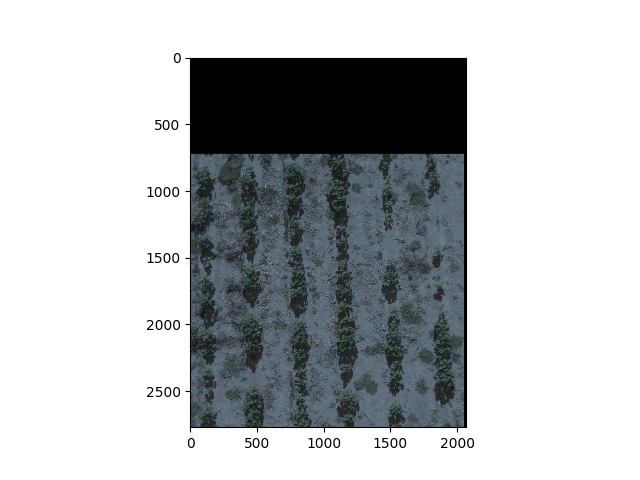

In [53]:
plt.imshow(base_img_warp)

<IPython.core.display.Javascript object>


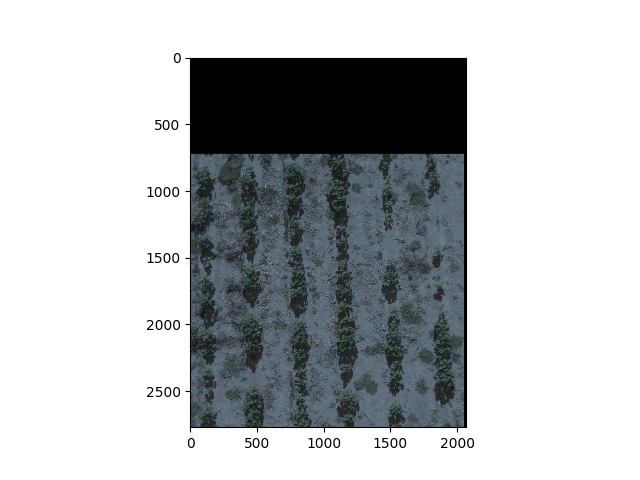

In [41]:
plt.imshow(next_img_warp)

<IPython.core.display.Javascript object>


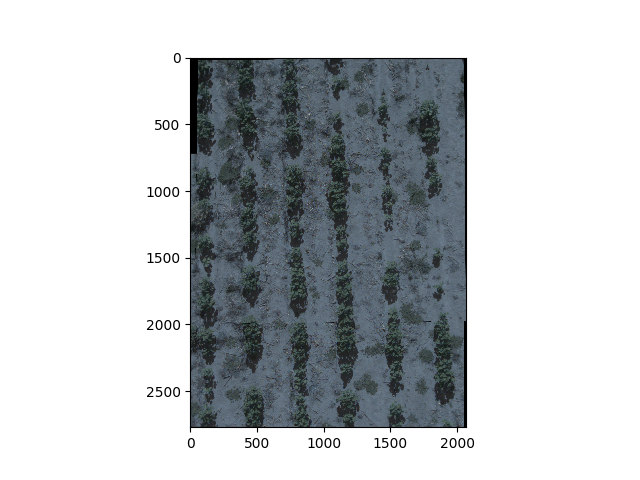

In [54]:
plt.imshow(final_img)